In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false" # Avoids warning from tokenizer when using num_workers > 0 in DataLoader

/Users/lea/anaconda3/envs/INF265/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Encoder-only Transformer for Text Sentiment Classification

## 1. Data

### 1.1 Load the IMDB dataset

We will use the IMDB dataset for sentiment classification. The dataset consists of 50,000 movie reviews, each labeled as positive or negative. We will use 25k reviews for training, 5k for validation, and 20k for testing.

In [2]:
# Constants
SEED = 420
VAL_SIZE = 0.2

# Load IMDB dataset
dataset_train = load_dataset("imdb", split="train")
dataset_test = load_dataset("imdb", split="test")

# Split test into test and validation
dataset_test = dataset_test.train_test_split(test_size=1-VAL_SIZE, seed=SEED)
dataset_test, dataset_val = dataset_test["test"], dataset_test["train"]

print(f"Train size: {len(dataset_train)}")
print(f"Validation size: {len(dataset_val)}")
print(f"Test size: {len(dataset_test)}")

Generating unsupervised split: 100%|██████████| 50000/50000 [00:00<00:00, 740854.62 examples/s]


Train size: 25000
Validation size: 5000
Test size: 20000


### 1.2 Preprocess the data

We remove HTML tags, special characters, and convert the text to lowercase.

In [3]:
def remove_html_tags(text):
    # Remove HTML tags
    return re.sub(r'<[^>]*>', '', text)

def remove_special_characters(text):
    # Remove special characters except for ,.!? and space
    return re.sub(r'[^a-zA-Z0-9.,!? ]', '', text)

def to_lowercase(text):
    # Convert text to lowercase
    return text.lower()

def preprocess_text(text):
    # Apply all preprocessing steps to the text
    text = remove_html_tags(text)
    text = remove_special_characters(text)
    text = to_lowercase(text)
    return text

def preprocess_batch(examples):
    # Apply preprocessing to all texts in the batch
    examples["text"] = [preprocess_text(text) for text in examples["text"]]
    return examples

# Preprocess the dataset
dataset_train = dataset_train.map(preprocess_batch, batched=True)
dataset_val = dataset_val.map(preprocess_batch, batched=True)
dataset_test = dataset_test.map(preprocess_batch, batched=True)

Map: 100%|██████████| 20000/20000 [00:00<00:00, 37909.75 examples/s]


### 1.3 Tokenization

We use a simple word-level tokenizer to tokenize the text data. We use three special tokens: `[PAD]`, `[UNK]` and `[CLS]`. The `[PAD]` token will be used to pad the input sequences to the same length. The `[UNK]` token is used to represent out-of-vocabulary words (rare words). When classifying text, we will prepend the `[CLS]` token to the input sequence and use its output as the representation of the whole sequence.

To reduce the vocabulary size, we only keep words appearing at least `MIN_FREQUENCY` times in the training set.

In [4]:
# Special tokens (padding, unknown, classification)
PAD_TOKEN = "[PAD]"
UNK_TOKEN = "[UNK]"
CLS_TOKEN = "[CLS]"
MIN_FREQUENCY = 10
VOCAB_SIZE = 10000

# Tokenizer setup
tokenizer = Tokenizer(WordLevel(unk_token=UNK_TOKEN))
tokenizer.pre_tokenizer = Whitespace() # Split on whitespace

# Train tokenizer on the training set
trainer = WordLevelTrainer(special_tokens=[PAD_TOKEN, UNK_TOKEN, CLS_TOKEN], min_frequency=MIN_FREQUENCY, vocab_size=VOCAB_SIZE)
tokenizer.train_from_iterator(dataset_train["text"], trainer)

We test the tokenizer on a few examples to verify that it works as expected.

In [5]:
for idx in range(5):
    example = dataset_train[idx]
    original_text = example["text"]
    tokenized_text = tokenizer.encode(example["text"])
    decoded_text = tokenizer.decode(tokenized_text.ids, skip_special_tokens=False)

    print(f"Original text: {original_text}")
    print(f"Tokenized text (tokens): {tokenized_text.tokens}")
    print(f"Tokenized text (IDs): {tokenized_text.ids}")
    print(f"Decoded text: {decoded_text}")
    print()

Original text: i rented i am curiousyellow from my video store because of all the controversy that surrounded it when it was first released in 1967. i also heard that at first it was seized by u.s. customs if it ever tried to enter this country, therefore being a fan of films considered controversial i really had to see this for myself.the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life. in particular she wants to focus her attentions to making some sort of documentary on what the average swede thought about certain political issues such as the vietnam war and race issues in the united states. in between asking politicians and ordinary denizens of stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.what kills me about i am curiousyellow is that 40 years ago, this was considered pornographic. really, the sex and nudity scenes are few and far between, even then its no

We plot the distribution of the sequence lengths in the training set. Later, we can use this to determine the maximum sequence length to use.

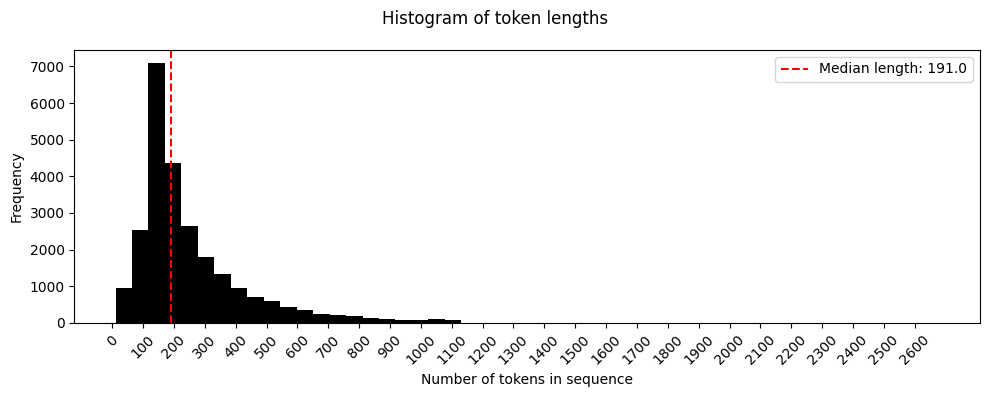

In [6]:
# Histogram of token lengths
token_lengths = [len(tokenizer.encode(text).ids) for text in dataset_train["text"]]
median_length = np.median(token_lengths)

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(token_lengths, bins=50, color="black")
ax.set_xticks(np.arange(0, np.max(token_lengths) + 1, 100))
ax.tick_params(axis="x", labelrotation=45)
ax.set_xlabel("Number of tokens in sequence")
ax.set_ylabel("Frequency")
ax.axvline(median_length, color="red", linestyle="--", label=f"Median length: {median_length}")
ax.legend()
fig.suptitle("Histogram of token lengths")
fig.tight_layout()
plt.show()

### 1.4 Dataset and Data Loaders

To deal with sequences of different lengths, we implement a simple `IMDBDataset` class that pads the sequences to the same length using the `[PAD]` token, or truncates them if they exceed the maximum sequence length. We also prepend the `[CLS]` token to the input sequences.

In [7]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length, pad_idx, cls_idx):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.pad_idx = pad_idx
        self.cls_idx = cls_idx
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        # TODO ✅
        text = self.texts[idx]
        label = self.labels[idx]
        
        tokenized = self.tokenizer.encode(text).ids
        tokenized = [self.cls_idx] + tokenized
        
        if len(tokenized) < self.max_length:
            tokenized = tokenized + [self.pad_idx] * (self.max_length - len(tokenized))
        else:
            tokenized = tokenized[:self.max_length]
            #konverterer til tensor i retunen 
        return torch.tensor(tokenized), torch.tensor(label)

We create some constants:

- `MAX_LENGTH`: the maximum sequence length
- `PAD_ID`: the ID of the `[PAD]` token
- `CLS_ID`: the ID of the `[CLS]` token
- `BATCH_SIZE`: the batch size
- `NUM_WORKERS`: the number of workers for data loading (set this to 0 if you are encountering issues with the DataLoader)

We also create the training and testing datasets and data loaders.

In [8]:
# Constants
MAX_LENGTH = 256
PAD_ID = tokenizer.token_to_id(PAD_TOKEN)
CLS_ID = tokenizer.token_to_id(CLS_TOKEN)
BATCH_SIZE = 64
NUM_WORKERS = 4

# Dataset instances
train_dataset = IMDBDataset(dataset_train["text"], dataset_train["label"], tokenizer, MAX_LENGTH, PAD_ID, CLS_ID)
val_dataset = IMDBDataset(dataset_val["text"], dataset_val["label"], tokenizer, MAX_LENGTH, PAD_ID, CLS_ID)
test_dataset = IMDBDataset(dataset_test["text"], dataset_test["label"], tokenizer, MAX_LENGTH, PAD_ID, CLS_ID)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, generator=torch.Generator().manual_seed(SEED))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

## 2. Model

### 2.1 Training Loop

We define a simple train function that takes `model` and trains it for `num_epochs` on `train_loader`. We give the `criterion` (loss function) and `optimizer` as arguments to the function. The train function also needs to know `pad_id`, the ID of the `[PAD]` token so we can generate the attention mask making sure the model does not attend to the padding tokens. After each epoch, we evaluate the model on `val_loader`.

In [9]:
def create_mask(sequences, pad_id):
    """
    Input shape of token sequences: (batch_size, seq_length)
    Output shape: (batch_size, seq_length) boolean mask with True where the padding tokens are located
    """
    # TODO ✅
    # returnerer en boolsk maske samme form som seqence 
    # True er pad tolken 
    return sequences == pad_id

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, pad_id):
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        correct, total = 0, 0
        for sequences, labels in (pbar := tqdm(train_loader)):
            labels = labels.float()
            optimizer.zero_grad()
            attention_mask = create_mask(sequences, pad_id)
            outputs = model(sequences, mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)  # Clip gradients for stability
            optimizer.step()
            train_losses.append(loss.item())
            correct += ((outputs > 0.5) == labels).sum().item()
            total += labels.size(0)
            pbar.set_description(f"Epoch {epoch+1}, Train Loss: {np.mean(train_losses):.4f}, Train Acc.: {correct / total:.4f}")

        # Validation
        model.eval()
        val_losses = []
        correct, total = 0, 0
        with torch.no_grad():
            for sequences, labels in tqdm(val_loader):
                labels = labels.float()
                attention_mask = create_mask(sequences, pad_id)
                outputs = model(sequences, mask=attention_mask)
                loss = criterion(outputs, labels)
                val_losses.append(loss.item())
                correct += ((outputs > 0.5) == labels).sum().item()
                total += labels.size(0)
        print(f"Epoch {epoch+1}, Val Loss: {np.mean(val_losses):.4f}, Val Acc.: {correct / total:.4f}")


### 2.2 Multi-Head Attention

We implement the multi-head attention mechanism. The multi-head attention mechanism consists of `num_heads` independent attention mechanisms. We concatenate the outputs of the different heads and project them back to the model's dimension. We use the scaled dot-product attention mechanism.

In [10]:
class MultiheadAttention(nn.Module):
    def __init__(self, dim, num_heads):
        """
        Multihead attention module.
        Args:
            dim: Dimension of the input vectors
            num_heads: Number of attention heads
            dropout: Dropout rate for attention scores (default: 0.1)
        """
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads

        assert dim % num_heads == 0, f"Dimension {dim} must be divisible by num_heads {num_heads}"

        self.head_dim = dim // num_heads

        # TODO: Linear transformations for query, key, and value
        # ✅
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)

        # TODO: Output linear transformation
        # ✅
        self.out_proj = nn.Linear(dim, dim)

    def forward(self, query, key, value, key_padding_mask):
        # TODO: Implement this method
        # ✅
        # linær transformation af query, key og value
        batch_size, seq_length, _ = query.size()
        
        # Lineær transformasjon
        Q = self.query(query)  # (batch_size, seq_length, dim)
        K = self.key(key)
        V = self.value(value)
        
        # endre form 
        # (batch_size, num_heads, seq_length, head_dim)
        Q = Q.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Skalerte 
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.head_dim)
        # scores: (batch_size, num_heads, seq_length, seq_length)
        
        if key_padding_mask is not None:
            # Utvid masken til å passe score-dimensjonen
            mask = key_padding_mask.unsqueeze(1).unsqueeze(2)  
            scores = scores.masked_fill(mask, float('-inf'))
        
        # Softmax for å få attention-vektene
        attn_weights = torch.softmax(scores, dim=-1)
        # attn_weights: (batch_size, num_heads, seq_length, seq_length)
        attn_output = torch.matmul(attn_weights, V) 
        # attn_output: (batch_size, num_heads, seq_length, head_dim)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_length, self.dim)
        
        # Output-projeksjon
        output = self.out_proj(attn_output)
        return output

### 2.3 Encoder Block

We implement the encoder block, which consists of our multi-head attention layer followed by a feedforward neural network. We also add residual connections and layer normalizations as specified in the project description.

In [11]:
class EncoderBlock(nn.Module):
    def __init__(self, dim, num_heads, dropout=0.1):
        super().__init__()
        # TODO: Implement this method ✅
        super().__init__()
        self.attention = MultiheadAttention(dim, num_heads)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)
        
        # Feedforward-nettverk 
        self.ff = nn.Sequential(
            nn.Linear(dim, 4 * dim),
            nn.GELU(),
            nn.Linear(4 * dim, dim)
        )
    def forward(self, x, mask=None):
        # TODO: Implement this method ✅
        # multihead attention med residual connection og layer norm
        attn_out = self.attention(x, x, x, key_padding_mask=mask)
        x = self.norm1(x + self.dropout(attn_out))
        
        # feedforward med residual connection og layer norm
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))
        return x
        

### 2.4 Model Specification

We specify our classifier model, which consists of an embedding layer, followed by `num_layers` encoder blocks. We use a linear layer to project the output of the last encoder block and apply sigmoid activation to get the final output.

We also define the positional encoding, which is added to the input embeddings to give the model information about the position of the tokens in the sequence.

In [12]:
class PositionalEncoding(nn.Module):
    """
    Positional encoding module: adds positional information to the input embeddings.
    """
    def __init__(self, embed_size, max_len):
        super().__init__()
        # TODO: Implement this method ✅
        super().__init__()
        pe = torch.zeros(max_len, embed_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-np.log(10000.0) / embed_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, embed_size)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # TODO: Implement this method (add positional encodings to the input embeddings x) ✅
        seq_length = x.size(1)
        x = x + self.pe[:, :seq_length, :]
        return x

class SentimentTransformer(nn.Module):
    def __init__(self, vocab_size, max_len, embedding_dim, num_heads, num_layers, pad_idx, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.pos_encoder = PositionalEncoding(embedding_dim, max_len)
        
        self.encoder = nn.ModuleList([EncoderBlock(embedding_dim, num_heads, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(embedding_dim, 1)  # Output layer
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, mask=None):
        x = self.embedding(x)  # Shape: (batch_size, seq_len, embedding_dim)
        x = self.pos_encoder(x)  # Add positional encodings

        for encoder in self.encoder:
            x = encoder(x, mask=mask)

        x = x[:, 0, :]  # Take the first token's embedding (CLS token equivalent)

        return self.sigmoid(self.fc(x)).squeeze()


### 2.5 Training the Model

We can now train the model. It is recommended that you use the parameters provided in the cell below as they should work pretty good without requiring too much computational power.

Train the model for (at least) 3 epochs. Each epoch should take around 7 to 12 minutes on a modern CPU. If you are training on a laptop, make sure it is plugged in. Moreover, closing all other applications can also help. Take a well-deserved break while the model trains.

If you struggle with extremely long training times, you can do one or more of the following to speed up training:

- Increase `MIN_FREQUENCY` and re-train the tokenizer to reduce the vocabulary size.
- Use a subset of the training data.
- Reduce the number of epochs.
- Reduce the maximum sequence length.
- Experiment with `NUM_WORKERS` in the data loaders (optimal value is system-dependent).
- If you have a GPU, modify the training function above to use it.

Expect to observe a training accuracy above `0.60` halfway through the first epoch.

In [13]:
NUM_EPOCHS = 3
LR = 1e-3
WEIGHT_DECAY = 1e-3
EMBEDDING_DIM = 96
NUM_HEADS = 4
NUM_LAYERS = 3

model = SentimentTransformer(vocab_size=VOCAB_SIZE, 
                             max_len=MAX_LENGTH,
                             embedding_dim=EMBEDDING_DIM, 
                             num_heads=NUM_HEADS, 
                             num_layers=NUM_LAYERS, 
                             pad_idx=PAD_ID)

criterion = nn.BCELoss() # Model output should have sigmoid applied!
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

n_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {n_params}")

train_model(model=model,
            criterion=criterion,
            optimizer=optimizer,
            train_loader=train_loader,
            val_loader=val_loader,
            num_epochs=NUM_EPOCHS,
            pad_id=PAD_ID)

Number of parameters: 1295617


  0%|          | 0/391 [00:00<?, ?it/s]Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/lea/anaconda3/envs/INF265/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/lea/anaconda3/envs/INF265/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'IMDBDataset' on <module '__main__' (built-in)>


### 2.6 Evaluating the Model on Unseen Data

We evaluate the model on the test set and print the test accuracy.

In [ ]:
def evaluate_model(model, test_loader, pad_id):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for sequences, labels in tqdm(test_loader):
            attention_mask = create_mask(sequences, pad_id)
            outputs = model(sequences, mask=attention_mask)
            predictions = (outputs > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    return correct / total

accuracy = evaluate_model(model, test_loader, PAD_ID)
print(f"Accuracy (test): {accuracy:.4f}")

### 2.7 Testing the Model on Custom Examples

For fun, we test the model on some custom examples from IMDb.

In [ ]:
# Function to classify a single review
def classify_review(review, model, tokenizer, pad_idx, cls_idx, max_length):
    # TODO: Implement this function ✅
    # Remember to set the model to evaluation mode, preprocess the review, tokenize it with [CLS] token prepended, pad/truncate and create a mask before passing it to the model
    model.eval()
    # preprocess the review 
    preprocess = lambda x: tokenizer(x, padding=True, truncation=True, max_length=max_length, return_tensors='pt').input_ids
    review = preprocess(review)
    
    # Tokeniser
    tokenized = tokenizer.encode(preprocess).ids
    tokenized = [cls_idx] + tokenized
    
    # Truncate eller pad sekvensen til max_length
    if len(tokenized) > max_length:
        tokenized = tokenized[:max_length]
    else:
        tokenized = tokenized + [pad_idx] * (max_length - len(tokenized))
    
    # Konverter til tensor og legg til batch-dimensjon
    input_tensor = torch.tensor(tokenized, dtype=torch.long).unsqueeze(0)
    
    # Lag padding-masken
    mask = create_mask(input_tensor, pad_idx)
    
    # Kjør modellen
    with torch.no_grad():
        output = model(input_tensor, mask=mask)
    
    # Siden output er en sannsynlighet (etter sigmoid), bruk terskel på 0.5
    p = output.item()
    sentiment = "Positiv" if p > 0.5 else "Negativ"
    
    
    return sentiment, p


In [ ]:
# TODO: Classify some reviews chosen by you
class SentimentTransformer(nn.Module):
    def __init__(self, vocab_size, max_len, embedding_dim, num_heads, num_layers, pad_idx, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.pos_encoder = PositionalEncoding(embedding_dim, max_len)
        self.encoder = nn.ModuleList([
            EncoderBlock(embedding_dim, num_heads, dropout) for _ in range(num_layers)
        ])
        self.fc = nn.Linear(embedding_dim, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, mask=None):
        x = self.embedding(x)          # (batch_size, seq_length, embedding_dim)
        x = self.pos_encoder(x)
        for encoder_block in self.encoder:
            x = encoder_block(x, mask=mask)
        # Bruk den første tokenens embedding ([CLS]) for klassifisering
        x = x[:, 0, :]  
        return self.sigmoid(self.fc(x)).squeeze()
